## Demo POMDP: Early Lung Cancer Decision Model

This simplified POMDP simulates sequential medical decision-making under uncertainty for early-stage lung cancer.

### States (Hidden True Condition)
- `Healthy`: No disease
- `PreCancer`: Early signs of potential cancer
- `Cancer`: Developed cancer

### Actions (Medical Choices)
- `Wait`: Take no action, monitor
- `OrderCTScan`: Request a CT scan to get more information
- `StartTreatment`: Begin treatment immediately

### Observations
- `NoAbnormality`: Scan appears normal
- `SuspiciousFinding`: Scan shows something abnormal

In [1]:
states = ["Healthy", "PreCancer", "Cancer"]
actions = ["Wait", "OrderCTScan", "StartTreatment"]
observations = ["NoAbnormality", "SuspiciousFinding"]

## Transition Model: P(s' | s, a)

This defines how the patient's **true health state** changes after each action.

### Rules:

- **Wait**:
  - Healthy stays Healthy most of the time, but can develop PreCancer.
  - PreCancer may progress to Cancer.
  - Cancer remains Cancer.

- **OrderCTScan**:
  - Does **not affect the health state** — it's purely diagnostic.

- **StartTreatment**:
  - Can **regress disease** in PreCancer or Cancer.
  - Health may improve with some probability.

These transition probabilities are defined in a nested dictionary structure:  
`T[action][current_state][next_state]`

In [2]:
import numpy as np

# Transition probabilities: T[action][current_state][next_state]
T = {
    "Wait": {
        "Healthy":     {"Healthy": 0.9, "PreCancer": 0.1, "Cancer": 0.0},
        "PreCancer":   {"Healthy": 0.0, "PreCancer": 0.7, "Cancer": 0.3},
        "Cancer":      {"Healthy": 0.0, "PreCancer": 0.0, "Cancer": 1.0},
    },
    "OrderCTScan": {
        "Healthy":     {"Healthy": 1.0, "PreCancer": 0.0, "Cancer": 0.0},
        "PreCancer":   {"Healthy": 0.0, "PreCancer": 1.0, "Cancer": 0.0},
        "Cancer":      {"Healthy": 0.0, "PreCancer": 0.0, "Cancer": 1.0},
    },
    "StartTreatment": {
        "Healthy":     {"Healthy": 1.0, "PreCancer": 0.0, "Cancer": 0.0},
        "PreCancer":   {"Healthy": 0.6, "PreCancer": 0.4, "Cancer": 0.0},
        "Cancer":      {"Healthy": 0.2, "PreCancer": 0.3, "Cancer": 0.5},
    }
}

## Observation Model: P(o | s', a)

This defines how likely a doctor is to observe certain findings, given the **resulting state** `s'` after taking action `a`.

### Rules:

- **OrderCTScan**:
  - High chance of detecting abnormalities if the patient is in `PreCancer` or `Cancer`.
  - Small chance of false positives if the patient is `Healthy`.

- **Wait** and **StartTreatment**:
  - Do **not generate new diagnostic information** — always results in `NoAbnormality`.

Observations depend on the **resulting (current) state** after transition, not the previous state.

Structure:  
`O[action][resulting_state][observation]`

In [3]:
# Observation model: O[action][resulting_state][observation]
O = {
    "Wait": {
        "Healthy":     {"NoAbnormality": 1.0, "SuspiciousFinding": 0.0},
        "PreCancer":   {"NoAbnormality": 1.0, "SuspiciousFinding": 0.0},
        "Cancer":      {"NoAbnormality": 1.0, "SuspiciousFinding": 0.0},
    },
    "OrderCTScan": {
        "Healthy":     {"NoAbnormality": 0.95, "SuspiciousFinding": 0.05},
        "PreCancer":   {"NoAbnormality": 0.3,  "SuspiciousFinding": 0.7},
        "Cancer":      {"NoAbnormality": 0.1,  "SuspiciousFinding": 0.9},
    },
    "StartTreatment": {
        "Healthy":     {"NoAbnormality": 1.0, "SuspiciousFinding": 0.0},
        "PreCancer":   {"NoAbnormality": 1.0, "SuspiciousFinding": 0.0},
        "Cancer":      {"NoAbnormality": 1.0, "SuspiciousFinding": 0.0},
    }
}

## Diagnosis Update (Bayes' Rule)

After taking an action and receiving an observation, we update our **diagnosis** — the probability distribution over the patient's true condition — using:

$$
\text{diagnosis}(s') = \eta \cdot P(o \mid s', a) \cdot \sum_{s} P(s' \mid s, a) \cdot \text{diagnosis}(s)
$$

Where:

- `diagnosis(s)`: current diagnosis (subjective probability) for state $s$
- $P(s' \mid s, a)$: transition probability to resulting state $s'$
- $P(o \mid s', a)$: observation likelihood in resulting state $s'$
- $\eta$: normalization constant to ensure probabilities sum to 1

This update is implemented in the `update_diagnosis` function.

In [4]:
def update_diagnosis(diagnosis, action, observation, states, T, O):
    updated = {}
    for s_prime in states:
        prob_obs = O[action][s_prime][observation]
        total = 0.0
        for s in states:
            total += T[action][s][s_prime] * diagnosis[s]
        updated[s_prime] = prob_obs * total
    # Normalize
    total_prob = sum(updated.values())
    for s in states:
        updated[s] /= total_prob
    return updated

## Simulate One Step

This function simulates a single step in the patient's trajectory under uncertainty. It performs:

1. **State Transition**: Given the current true state and action, a new resulting state is sampled using the transition model \( P(s' \mid s, a) \).
2. **Observation Generation**: Based on the resulting state and action, an observation is sampled using \( P(o \mid s', a) \).
3. **Diagnosis Update**: The agent's diagnosis (belief over states) is updated using Bayes' Rule, based on the observation and action.

### Inputs:
- `true_state`: The actual (hidden) current state of the patient.
- `diagnosis`: The agent's current belief (probability distribution over states).
- `action`: Action taken by the agent (e.g., "Wait", "OrderCTScan").
- `states`, `T`, `O`: State space, transition model, and observation model.

### Output:
- `resulting_state`: The new true state after transition.
- `observation`: The simulated observation from the environment.
- `updated_diagnosis`: The revised diagnosis after processing the observation.

In [5]:
import random

def simulate_step(true_state, diagnosis, action, states, T, O):
    # Transition to new true state
    resulting_state = random.choices(
        states,
        weights=[T[action][true_state][s_prime] for s_prime in states]
    )[0]

    # Sample observation based on resulting state
    obs_weights = [O[action][resulting_state][o] for o in observations]
    observation = random.choices(observations, weights=obs_weights)[0]

    # Update diagnosis
    updated_diagnosis = update_diagnosis(diagnosis, action, observation, states, T, O)

    return resulting_state, observation, updated_diagnosis

## Simulate a Single Diagnostic Step

This cell demonstrates how to simulate a **single decision-making step** in the POMDP model:

1. **Initial Diagnosis**: Starts with a uniform belief across all health states.
2. **True State Sampling**: Samples a hidden true state based on the initial diagnosis.
3. **Action Selection**: Manually selects an action (`"OrderCTScan"`).
4. **Simulation**: 
   - Transitions the true state.
   - Generates an observation.
   - Updates the agent's diagnosis using Bayes' Rule.

### Outputs:
- `true_state`: The resulting hidden health state after transition.
- `observation`: What the agent sees (e.g., scan result).
- `updated_diagnosis`: The agent's revised probability distribution over possible patient states.

In [6]:
initial_diagnosis = {
    "Healthy": 1/3,
    "PreCancer": 1/3,
    "Cancer": 1/3
}

# Sample initial true state
true_state = random.choices(states, weights=[initial_diagnosis[s] for s in states])[0]

# Simulate one step
action = "OrderCTScan"
true_state, observation, updated_diagnosis = simulate_step(true_state, initial_diagnosis, action, states, T, O)

# Print result
print(f"Sampled resulting state: {true_state}, observation: {observation}")
print("Updated diagnosis:")
for state, prob in updated_diagnosis.items():
    print(f"  {state}: {prob:.3f}")

Sampled resulting state: PreCancer, observation: SuspiciousFinding
Updated diagnosis:
  Healthy: 0.030
  PreCancer: 0.424
  Cancer: 0.545


## Action Selection Strategy: Greedy Policy

To choose actions based on current diagnosis, we define a **reward table** for each state-action pair.

At each decision step, we select the action that maximizes the **expected immediate reward**, weighted by the diagnosis probabilities:

$$
\text{ExpectedReward}(a) = \sum_{s} \text{diagnosis}(s) \cdot R(s, a)
$$

This is implemented in the `select_greedy_action` function.

In [7]:
# Reward[state][action]
R = {
    "Healthy":   {"Wait":  5, "OrderCTScan": -1, "StartTreatment": -10},
    "PreCancer": {"Wait": -2, "OrderCTScan": -1, "StartTreatment": 5},
    "Cancer":    {"Wait": -10, "OrderCTScan": -1, "StartTreatment": 10}
}

In [8]:
def select_greedy_action(diagnosis, actions, R):
    best_action = None
    best_value = float("-inf")
    for action in actions:
        expected_reward = sum(diagnosis[s] * R[s][action] for s in diagnosis)
        if expected_reward > best_value:
            best_value = expected_reward
            best_action = action
    return best_action

## Simulate a Full Episode

We simulate a sequence of decision steps using the greedy policy:

1. Select the action with the highest expected reward.
2. Simulate the result (transition + observation).
3. Update diagnosis.
4. Track outcomes for analysis.

Each step logs:
- Chosen action
- Observation
- Updated diagnosis
- Expected reward

The full episode is run by the `run_episode` function.

In [9]:
## 🎬 Run a Full Episode

This function simulates a full episode (i.e., a sequence of decision steps) for a **single patient** under uncertainty.

### What It Does:
1. **Initial Setup**:
   - Starts from an initial diagnosis (subjective belief).
   - Samples a hidden true initial state.

2. **Per Step (Loop)**:
   - Chooses an action using a greedy policy.
   - Computes the **true reward** based on the hidden state.
   - Transitions the true state and generates an observation.
   - Updates the diagnosis based on observation.
   - Logs step data.

3. **Returns**:
   - `history`: List of step-level logs containing actions, observations, diagnosis, reward, and true state.
   - `total_reward`: Sum of actual (true state-based) rewards over the episode.

### Parameters:
- `initial_diagnosis`: Initial belief distribution over patient states.
- `steps`: Number of time steps to simulate.
- `states`, `actions`: The state and action spaces.
- `T`, `O`, `R`: Transition model, observation model, and reward function.


## Run a Full Episode

This function simulates a full episode (i.e., a sequence of decision steps) for a **single patient** under uncertainty.

### What It Does:
1. **Initial Setup**:
   - Starts from an initial diagnosis (subjective belief).
   - Samples a hidden true initial state.

2. **Per Step (Loop)**:
   - Chooses an action using a greedy policy.
   - Computes the **true reward** based on the hidden state.
   - Transitions the true state and generates an observation.
   - Updates the diagnosis based on observation.
   - Logs step data.

3. **Returns**:
   - `history`: List of step-level logs containing actions, observations, diagnosis, reward, and true state.
   - `total_reward`: Sum of actual (true state-based) rewards over the episode.

### Parameters:
- `initial_diagnosis`: Initial belief distribution over patient states.
- `steps`: Number of time steps to simulate.
- `states`, `actions`: The state and action spaces.
- `T`, `O`, `R`: Transition model, observation model, and reward function.

In [10]:
# Run one episode

initial_diagnosis = {
    "Healthy": 1/3,
    "PreCancer": 1/3,
    "Cancer": 1/3
}

# call to run_episode
episode, total_reward = run_episode(
    initial_diagnosis=initial_diagnosis,
    steps=5,
    states=states,
    actions=actions,
    T=T,
    O=O,
    R=R
)

# Print each step clearly
for step in episode:
    print(f"Step {step['step']}:")
    print(f"  Action taken: {step['action']}")
    print(f"  Observation: {step['observation']}")
    print(f"  True state: {step['true_state']}")
    print("  Diagnosis:")
    for state, prob in step["diagnosis"].items():
        print(f"    {state}: {prob:.3f}")
    print(f"  Step reward: {step['reward']:.2f}")
    print("-" * 40)

print(f"\n Total reward over this episode: {total_reward:.2f}")

Step 1:
  Action taken: StartTreatment
  Observation: NoAbnormality
  True state: Healthy
  Diagnosis:
    Healthy: 0.600
    PreCancer: 0.233
    Cancer: 0.167
  Step reward: -10.00
----------------------------------------
Step 2:
  Action taken: Wait
  Observation: NoAbnormality
  True state: Healthy
  Diagnosis:
    Healthy: 0.540
    PreCancer: 0.223
    Cancer: 0.237
  Step reward: 5.00
----------------------------------------
Step 3:
  Action taken: Wait
  Observation: NoAbnormality
  True state: Healthy
  Diagnosis:
    Healthy: 0.486
    PreCancer: 0.210
    Cancer: 0.304
  Step reward: 5.00
----------------------------------------
Step 4:
  Action taken: StartTreatment
  Observation: NoAbnormality
  True state: Healthy
  Diagnosis:
    Healthy: 0.673
    PreCancer: 0.175
    Cancer: 0.152
  Step reward: -10.00
----------------------------------------
Step 5:
  Action taken: Wait
  Observation: NoAbnormality
  True state: Healthy
  Diagnosis:
    Healthy: 0.606
    PreCancer: 0

## Evaluate a Strategy

This function evaluates a given decision-making strategy (policy) by simulating it over multiple patient episodes.

### What It Does:
- Runs `n_episodes` simulations using the specified `policy_fn`.
- For each episode:
  - Simulates sequential decisions and state transitions.
  - Accumulates the total reward based on the **true hidden states**.
- Collects total rewards from each episode to analyze strategy performance.

### Parameters:
- `policy_fn`: A function that selects actions based on the current diagnosis (e.g., greedy policy).
- `n_episodes`: Number of independent episodes (simulated patients).
- `initial_diagnosis`: Initial belief distribution used in all episodes.
- `**kwargs`: Passed directly to `run_episode` (e.g., `states`, `actions`, `T`, `O`, `R`).

### Returns:
- `total_rewards`: A list of total rewards (one per episode), which can be averaged or plotted for analysis.

In [12]:
def evaluate_strategy(policy_fn, n_episodes, initial_diagnosis, **kwargs):
    total_rewards = []
    for _ in range(n_episodes):
        _, reward = run_episode(initial_diagnosis, steps=5, **kwargs)
        total_rewards.append(reward)
    return total_rewards

## Plot: Average Reward vs. Number of Simulated Patients

This cell evaluates the greedy policy over increasing sample sizes to analyze **reward stability** and **convergence**.

### What It Does:
- Iteratively runs `evaluate_strategy()` with patient counts ranging from 2,000 to 98,000.
- For each sample size:
  - Computes the average total reward.
- Plots how the average reward behaves as the number of simulated patients increases.

### Plot:
- **X-axis**: Number of simulated patients (episodes).
- **Y-axis**: Average total reward across episodes.
- **Purpose**: Visualize convergence and stability of policy performance with larger samples.

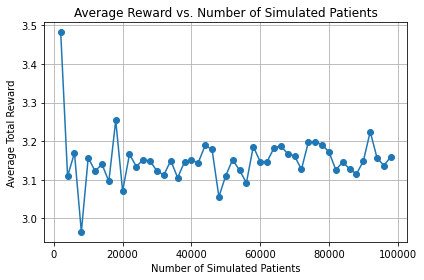

In [13]:
import matplotlib.pyplot as plt

sample_sizes = list(range(2000, 100000, 2000))
average_rewards = []

for n in sample_sizes:
    greedy_rewards = evaluate_strategy(
        select_greedy_action,
        n_episodes=n,
        initial_diagnosis={"Healthy": 1/3, "PreCancer": 1/3, "Cancer": 1/3},
        states=states,
        actions=actions,
        T=T,
        O=O,
        R=R
    )
    avg_reward = np.mean(greedy_rewards)
    average_rewards.append(avg_reward)

# Plot
plt.plot(sample_sizes, average_rewards, marker='o')
plt.title("Average Reward vs. Number of Simulated Patients")
plt.xlabel("Number of Simulated Patients")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()